In [1]:
import os,sys
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_point, theme_minimal, labs, theme, element_text, scale_y_continuous, element_line, geom_smooth, annotate, coord_cartesian
from mizani.formatters import scientific_format
from scipy.stats import linregress

In [2]:
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
%matplotlib inline

In [3]:
plt.rcParams['svg.fonttype'] = 'none'

In [40]:
mums = [l.split() for l in open('output/potato_chr3.mums', 'r').read().splitlines()]
mums = [(int(l[0]), [int(v) for v in l[1].split(',')], l[2].split(',')) for l in mums]
mums = [(l, np.array(starts[1:] + [starts[0]]), np.array(strands[1:] + [strands[0]])) for l, starts, strands in mums]
mums = sorted(mums, key=lambda x: x[1][0])

In [41]:
seq_lengths = [int(l.split()[1]) for l in open('output/potato_chr3.lengths', 'r').read().splitlines()]
seq_lengths = np.array(seq_lengths[1:] + [seq_lengths[0]])

In [43]:
def find_coll_blocks(mums, MAX_BREAK=10000):
    starts = np.array([m[1] for m in mums])
    mum_orders = starts.transpose().argsort()
    mum_gaps = []
    flips = set([])
    for i in range(mum_orders.shape[0]):
        cur = []
        for l in range(1, mum_orders.shape[1]):
            left, right = mum_orders[i][l-1], mum_orders[i][l]
            if mums[left][2][i] == mums[right][2][i]:
                if mums[left][2][i] == '+':
                    cur.append((left, right))
                else:
                    cur.append((right, left))
                    flips.add((right, left))
        mum_gaps.append(cur)
    common_gaps = set.intersection(*map(set, mum_gaps))
    left, right = zip(*common_gaps)
    left, right = set(list(left)), set(list(right))
    true_collinear_mums = sorted(list(left.intersection(right)))
    right_coll_mums = sorted(list(left.difference(set(true_collinear_mums)))) # have a right pair, but not a left
    left_coll_mums = sorted(list(right.difference(set(true_collinear_mums)))) # have a left pair, but not a right
    large_blocks = list(zip(right_coll_mums, left_coll_mums))
    ### find the longest stretches of collinear mums
    small_blocks = []
    for l, r in large_blocks:
        last = l
        for i in range(l, r):
            lens = np.full(len(mums[i][1]), mums[i][0])
            lens[(mums[i+1][1] < mums[i][1])] = mums[i+1][0] 
            gap_lens = np.abs(mums[i][1] - mums[i+1][1]) - lens
            if gap_lens.max() > MAX_BREAK and last < i:
                small_blocks.append((last, i))
                last = i + 1
        if last != r:
            small_blocks.append((last, r))
    return large_blocks, small_blocks, mum_gaps

In [44]:
def get_block_order(mums, blocks):
    starts = np.array([m[1] for m in mums])
    mum_orders = starts.transpose().argsort()
    ### get coll_block order
    coll_block_starts = [b[0] for b in blocks]
    coll_block_orders = []
    for i in range(mum_orders.shape[0]):
        poi = np.where(np.isin(mum_orders[i], coll_block_starts))[0]
        values = mum_orders[i][poi]
        poi = np.argsort(values)
        coll_block_orders.append(np.argsort(poi))
    return coll_block_orders

In [45]:
large_blocks, small_blocks, mum_gaps = find_coll_blocks(mums, MAX_BREAK=1000)
coll_block_order = get_block_order(mums, small_blocks)

In [46]:
len(small_blocks), len(large_blocks)

(9250, 2623)

In [47]:
def draw_synteny_outline_inv(ax, genome_lengths, mums, outlines, mum_color='red', inv_color='darkred'):
    def points_to_poly(points):
        starts, ends = tuple(zip(*points))
        points = starts + ends[::-1]
        return points
    max_length = max(genome_lengths)
    for idx, g in enumerate(genome_lengths):
        ax.plot([0, g], [idx, idx], color='gray', alpha=0.2, linewidth=0.5)
    polygons = []
    colors = []
    for _, (l, r) in enumerate(outlines):
        strands = mums[l][2]
        inverted = strands[0] == '-'
        points = []
        left, right = mums[l][1], mums[r][1] + mums[r][0]
        for idx, strand in enumerate(strands):
            points.append(((left[idx], idx), (right[idx], idx)))
            if not inverted and strand == '-':
                inverted = True
                if len(points) > 2:
                    polygons.append(points_to_poly(points[:-1]))
                    colors.append(mum_color)
                polygons.append(points_to_poly(points[-2:]))
                colors.append(inv_color)
                points = [points[-1]]
            elif inverted and strand == '+':
                inverted = False
                if len(points) > 2:
                    polygons.append(points_to_poly(points[:-1]))
                    colors.append(mum_color)
                polygons.append(points_to_poly(points[-2:]))
                colors.append(inv_color)
                points = [points[-1]]
        if len(points) >= 2:
            polygons.append(points_to_poly(points))
            colors.append(mum_color)
    ax.add_collection(PolyCollection(polygons, linewidths=0, alpha=1, edgecolors=colors, facecolors=colors))
    ax.yaxis.set_ticks(range(len(genome_lengths)))
    ax.tick_params(axis='y', which='both',length=0)
    ax.yaxis.set_ticklabels([])
    ax.set_xlabel('bp')
    ax.set_ylabel('sequences')
    ax.set_ylim(0, len(genome_lengths)-1)
    ax.set_xlim(0, max_length)
    # ax.invert_yaxis()
    # fig.set_tight_layout(True)
    # fig.set_dpi(200)
    # ax.axis('off')
    return fig, ax

In [48]:
ann_fname = open('misc/potato_A6-26.gff', 'r')
ann = [l.strip().split() for l in ann_fname if l.startswith('A6-26_chr03') and l.split()[2] == 'gene' ]

TE_fname = open('misc/A6-26.repeat.EDTA.gff3', 'r').read().splitlines()
retro_ann = [l.strip().split() for l in TE_fname if l.startswith('A157_chr03') and l.split()[2].endswith('LTR_retrotransposon')]
tir_ann = [l.strip().split() for l in TE_fname if l.startswith('A157_chr03') and l.split()[2].endswith('TIR_transposon')]

In [12]:
mem_coverage = np.load('output/potato_chr3_coverage.npy')

/scratch4/blangme2/vshiv/conda/envs/basic/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/scratch4/blangme2/vshiv/conda/envs/basic/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


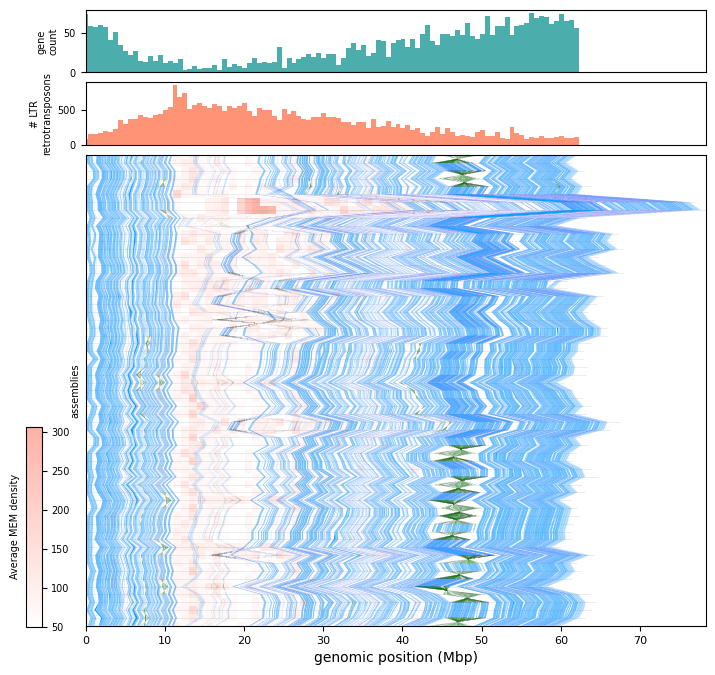

In [50]:
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure()

gs = fig.add_gridspec(3, 1, height_ratios=[1,1,7.5], hspace=0.05)

ax = fig.add_subplot(gs[2, 0])
draw_synteny_outline_inv(ax, seq_lengths, mums, small_blocks, mum_color='#00A2FF', inv_color='green')
ax.invert_yaxis()
ax.set_xlabel('genomic position (Mbp)')
ax.set_ylabel('assemblies', fontsize=7)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.axes.yaxis.set_ticks([])
ax.set_xticks([0, 1e7, 2e7, 3e7, 4e7, 5e7, 6e7, 7e7])
ax.set_xticklabels(map(str, [0, 10, 20, 30, 40, 50, 60, 70]))


ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.hist([int(a[3]) for a in ann], bins = 100, color='#008B8B', align='left', alpha=0.7)
ax_histx.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_histx.set_ylabel('gene\ncount', fontsize=7)
ax_histx.tick_params(axis='both', which='major', labelsize=7)

# green #1DB100A0
ax_histx = fig.add_subplot(gs[1, 0], sharex=ax)
ax_histx.hist([int(a[3]) for a in retro_ann], bins = 100, color=(1, 0.4, 0.235), align='left', alpha=0.7)
ax_histx.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax_histx.set_ylabel('# LTR\nretrotransposons', fontsize=7)
ax_histx.tick_params(axis='both', which='major', labelsize=7)


split = 1000000
heat_start = 0
heat_width = mem_coverage.shape[1]
mean_cov = np.stack([(mem_coverage[:, i*split:(i+1)*split]).mean(axis=1) for i in range(heat_width//split)]).T
cmap_colors = [(1, 1, 1), (1, 0.392, 0.306)]
cmap = LinearSegmentedColormap.from_list('custom_cmap', cmap_colors)
x = np.linspace(heat_start, heat_start + heat_width, mean_cov.shape[1] + 1)
y = np.linspace(-0.5, len(seq_lengths)-0.5, mean_cov.shape[0] + 1)
heat = ax.pcolormesh(x, y, mean_cov, cmap=cmap, alpha=0.5, shading='auto', zorder=0)
heat.set_clim(50)


fig.set_size_inches(8,8)
fig.set_tight_layout(True)

cbar_ax = fig.add_axes(tuple([0.05, 0.109, 0.02, 0.25]))  # [left, bottom, width, height]
cbar_ax.tick_params(labelsize=7)  # Make colorbar text smaller
cbar = fig.colorbar(heat, cax=cbar_ax)
cbar.set_label('Average MEM density', size=7, rotation=90)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.set_ticks_position('right')

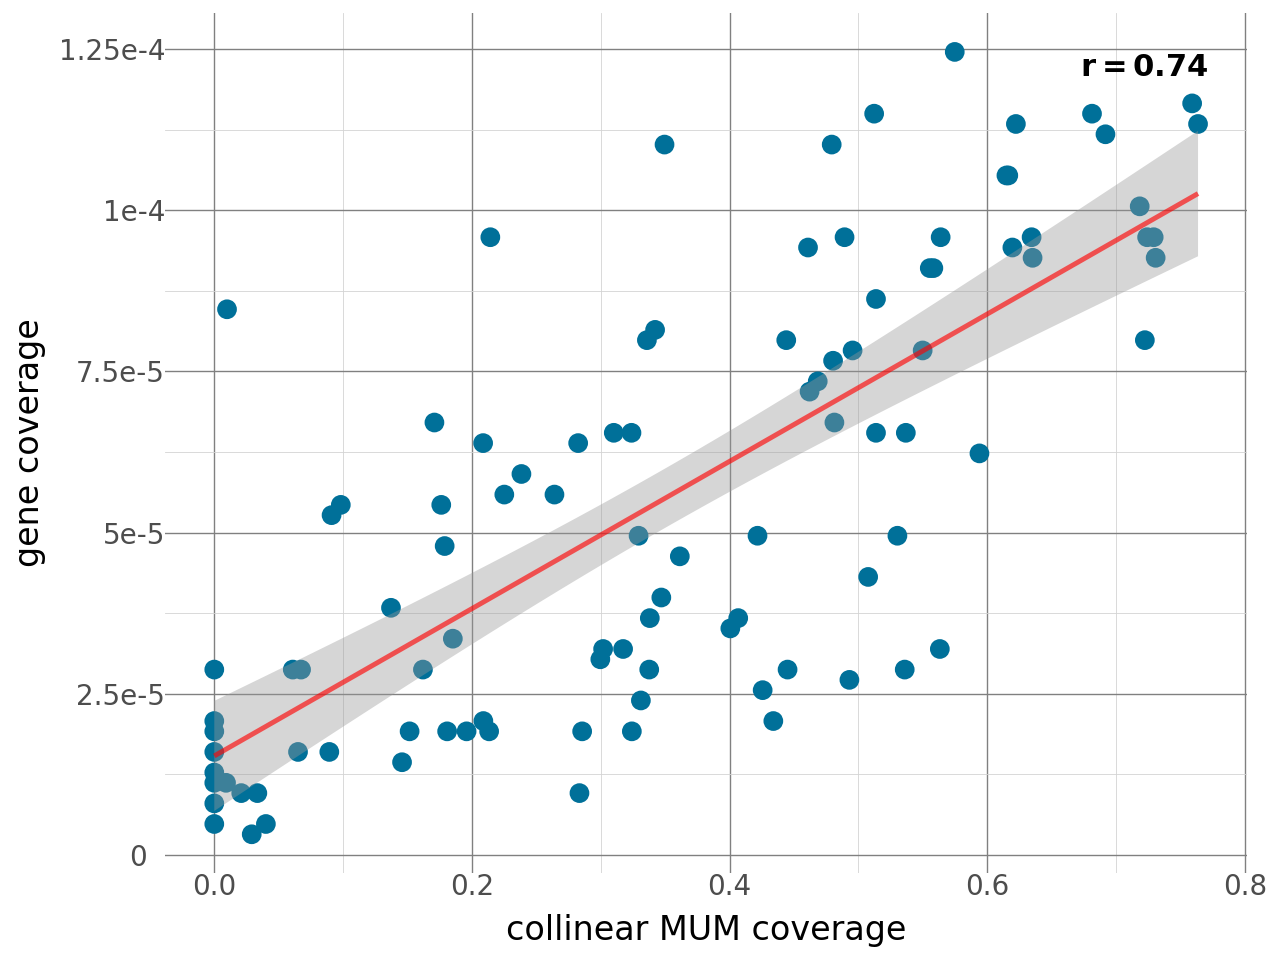

In [25]:
gene_cov = np.zeros(seq_lengths[0])
for a in ann:
    gene_cov[int(a[3]) - 1:int(a[3])] = True
    
mum_cov = np.zeros(seq_lengths[0])
for l, r in small_blocks:
    if mums[l][1][0] < mums[r][1][0]:
        mum_cov[mums[l][1][0] : mums[r][1][0] + mums[r][0]] = True
    else:
        mum_cov[mums[r][1][0] : mums[l][1][0] + mums[r][0]] = True

window_size = seq_lengths[0] // 100
gene_cov_block = [gene_cov[i : i + window_size].sum() / window_size for i in range(0, seq_lengths[0], window_size)]
mum_cov_block = [mum_cov[i : i + window_size].sum() / window_size for i in range(0, seq_lengths[0], window_size)]

# Create a DataFrame for plotnine
df = pd.DataFrame({'MUM coverage': mum_cov_block, 'Gene coverage': gene_cov_block})

slope, intercept, r_value, _, _ = linregress(mum_cov_block, gene_cov_block)

# Create the scatter plot
plot = (
    ggplot(df, aes(x='MUM coverage', y='Gene coverage')) +
    geom_point(size=3, color='#007099') +
    geom_smooth(method='lm', color='#FF0000A0', se=True) +  # Add trendline
    annotate("text", x=max(mum_cov_block)*0.945, y=max(gene_cov_block)*0.98, label=f'$\\mathbf{{r = {r_value:.2f}}}$', color="black") +  # Add R^2 text
    theme_minimal() +
    labs(
        x="collinear MUM coverage",
        y="gene coverage"
    ) +
    scale_y_continuous(labels=lambda x:[np.format_float_scientific(i,exp_digits=1, precision=2, trim='-') if i != 0 else "0  " for i in x]) +
    theme(
        plot_title=element_text(size=14, weight='bold', ha='center'),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        axis_text=element_text(size=10),
        panel_grid_major=element_line(color='grey', size=0.5),      # Set major grid line thickness
        panel_grid_minor=element_line(color='lightgrey', size=0.3) 
        # panel_grid_major=element_text(color='grey', size=0.5),  # Set major grid lines to grey
        # panel_grid_minor=element_text(color='lightgrey', size=0.3)  # Set minor grid lines to light grey
    )
)

# Display the plot
plot

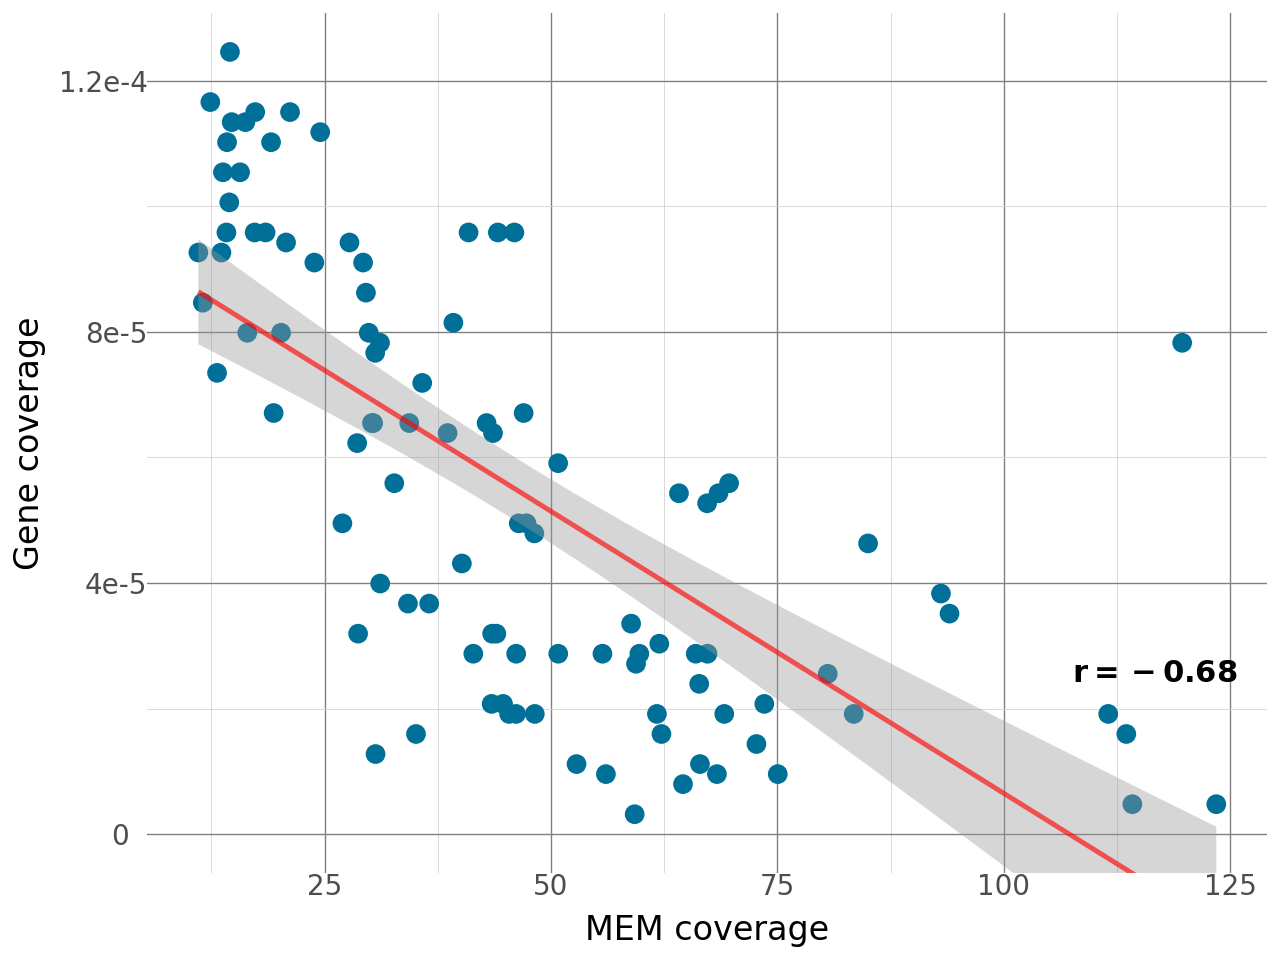

In [36]:
window_size = seq_lengths[0] // 100
mem_cov_block = [mem_coverage[0, i : i + window_size].sum() / window_size for i in range(0, seq_lengths[0], window_size)]

# Create a DataFrame for plotnine
df = pd.DataFrame({'MEM coverage': mem_cov_block, 'Gene coverage': gene_cov_block})

slope, intercept, r_value, _, _ = linregress(mem_cov_block, gene_cov_block)

# Create the scatter plot
plot = (
    ggplot(df, aes(x='MEM coverage', y='Gene coverage')) +
    geom_point(size=3, color='#007099') +
    geom_smooth(method='lm', color='#FF0000A0', se=True) +  # Add trendline
    coord_cartesian(ylim=(0, None)) + 
    annotate("text", x=max(mem_cov_block)*0.945, y=min(gene_cov_block)*8, label=f'$\\mathbf{{r = {r_value:.2f}}}$', color="black") +  # Add R^2 text
    theme_minimal() +
    labs(
        x="MEM coverage",
        y="Gene coverage"
    ) +
    scale_y_continuous(labels=lambda x:[np.format_float_scientific(i,exp_digits=1, precision=2, trim='-') if i != 0 else "0  " for i in x]) +
    theme(
        plot_title=element_text(size=14, weight='bold', ha='center'),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        axis_text=element_text(size=10),
        panel_grid_major=element_line(color='grey', size=0.5),      # Set major grid line thickness
        panel_grid_minor=element_line(color='lightgrey', size=0.3) 
        # panel_grid_major=element_text(color='grey', size=0.5),  # Set major grid lines to grey
        # panel_grid_minor=element_text(color='lightgrey', size=0.3)  # Set minor grid lines to light grey
    )
)
# Display the plot
plot

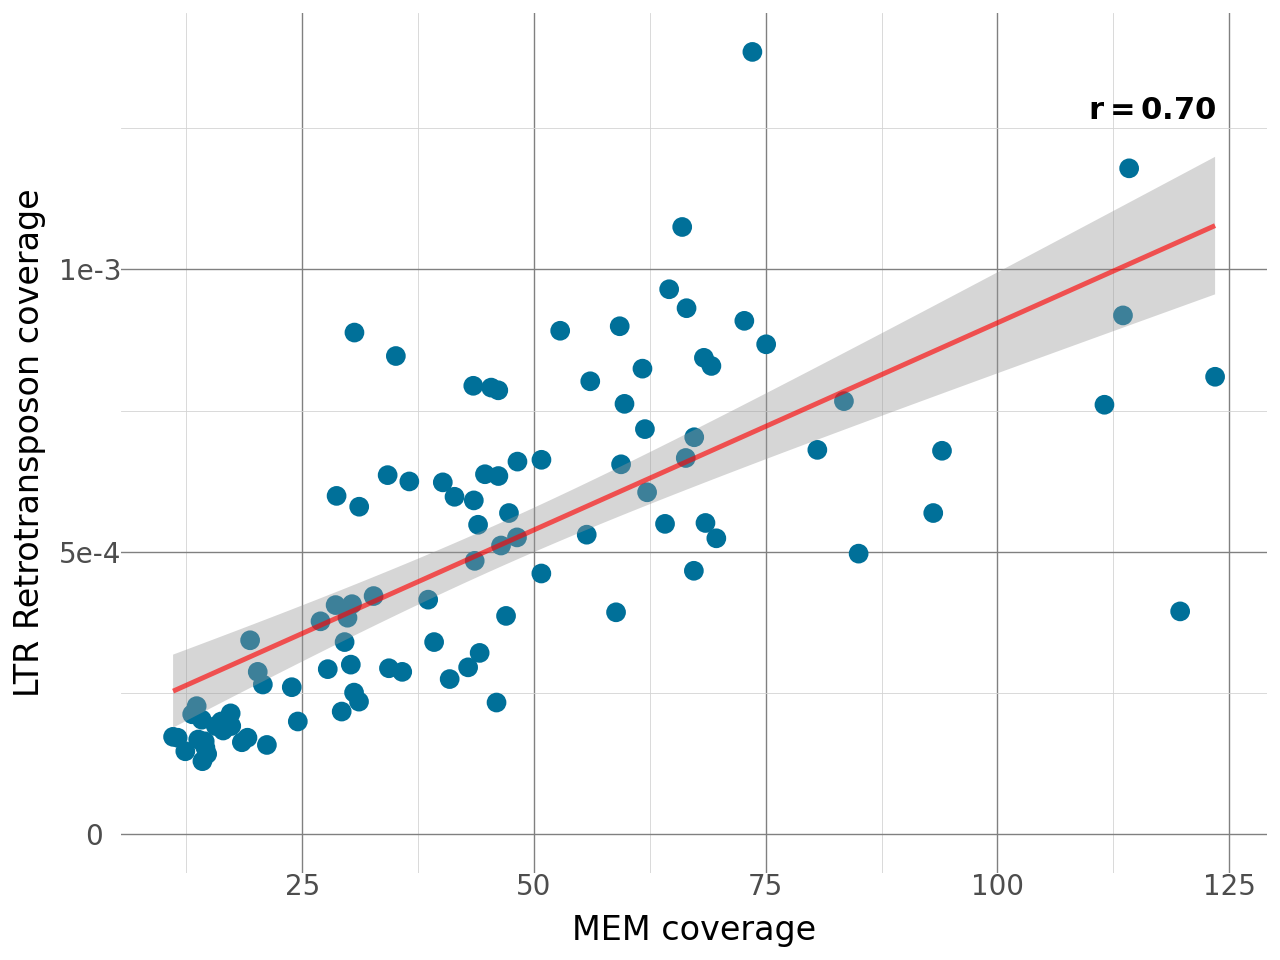

In [41]:
window_size = seq_lengths[0] // 100
retro_cov = np.zeros(seq_lengths[0])
for a in retro_ann:
    retro_cov[int(a[3]) - 1:int(a[3])] = True
retro_cov_block = [retro_cov[i : i + window_size].sum() / window_size for i in range(0, seq_lengths[0], window_size)]

# Create a DataFrame for plotnine
df = pd.DataFrame({'MEM coverage': mem_cov_block, 'LTR Retrotransposon coverage': retro_cov_block})

slope, intercept, r_value, _, _ = linregress(mem_cov_block, retro_cov_block)

# Create the scatter plot
plot = (
    ggplot(df, aes(x='MEM coverage', y='LTR Retrotransposon coverage')) +
    geom_point(size=3, color='#007099') +
    geom_smooth(method='lm', color='#FF0000A0', se=True) +  # Add trendline
    coord_cartesian(ylim=(0, None)) + 
    annotate("text", x=max(mem_cov_block)*0.945, y=max(retro_cov_block)*0.925, label=f'$\\mathbf{{r = {r_value:.2f}}}$', color="black") +  # Add R^2 text
    theme_minimal() +
    labs(
        x="MEM coverage",
        y="LTR Retrotransposon coverage"
    ) +
    scale_y_continuous(labels=lambda x:[np.format_float_scientific(i,exp_digits=1, precision=2, trim='-') if i != 0 else "0  " for i in x]) +
    theme(
        plot_title=element_text(size=14, weight='bold', ha='center'),
        axis_title_x=element_text(size=12),
        axis_title_y=element_text(size=12),
        axis_text=element_text(size=10),
        panel_grid_major=element_line(color='grey', size=0.5),      # Set major grid line thickness
        panel_grid_minor=element_line(color='lightgrey', size=0.3) 
        # panel_grid_major=element_text(color='grey', size=0.5),  # Set major grid lines to grey
        # panel_grid_minor=element_text(color='lightgrey', size=0.3)  # Set minor grid lines to light grey
    )
)
# Display the plot
plot